# peaks Tutorial 3: Nano ARPES
Use of peaks for handling spatial mapping datasets for nanoARPES/microARPES

In [2]:
#Import full PyPhoto package
import sys
import time
sys.path.insert(0, '../')
%load_ext autoreload
%autoreload 2
%aimport peaks
from peaks import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'ase'

NB, nano-ARPES files can be large! It is useful to do any operations possible to reduce the data, and clear out old variables to avoid clogging the memory. It is also useful to occassionally run gc.collect() to clear out the garbage. (gc is imported as part of the peaks global import).

## Focussing
Alingment (focussing) scan for nano-ARPES (this is essentially looking for increased sharpness as the beam is scanned across some feature on the sample). Several metrics for this are presented. Call as nanofocus(data) where data is the cube data from the focussing scan. This should be a 4D dataarray with some spatial direction of the scan, some focus direction, theta_par, and energy (xarray).

In [2]:
help(nanofocus)

Help on function nanofocus in module peaks.display.nanoARPES:

nanofocus(data, focus='defocus')
    Alingment (focussing) scan for nano-ARPES (essentially looking for increased sharpness as the beam is scanned across some feature)
    
    Input:
        data - the data from the focussing scan - 4D data with some spatial direction of scan, some focus direction, theta_par, and energy (xarray)
        focus (optional, default='defocus') - relevant co-ordinate of the focus direction
        
    Returns:
        Plot



In [54]:
# Load data (focussing scan)
a = load_data('example_data/i05-1-34243.nxs')

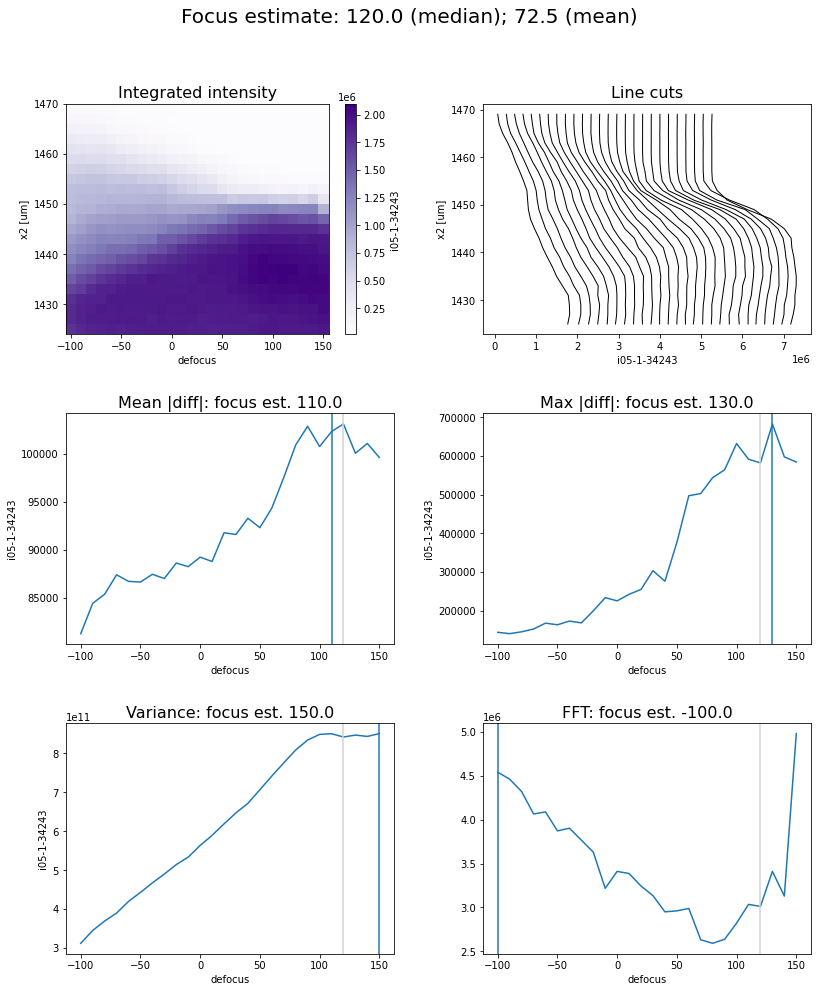

In [55]:
start = time.time()
nanofocus(a)

## Spatial map

Load data using the standard load_data command. For large files, this bins 2x2 in energy and angle, but alternative factors can be specified by calling with `binning=n` where `n` is an integer, or by passing a dictionary of the form `binning={ax: bin_factor}` for all axes to bin. To force no binning, set `binning=1`. Can pre-select a reduced range with `ax=slice(start,stop)` for any axes. By default, files are loaded to memory, but if the file is too big, this can be turned off using `persist=False` so that then the relevant loading is performed from disk in chunks as required.

In [2]:
%%time
# Load data (focussing scan)
a = load_data('example_data/i05-1-24270.nxs',binning=2,eV=slice(74,76.5),theta_par=slice(-18,18), persist=False)

CPU times: user 324 ms, sys: 32.1 ms, total: 356 ms
Wall time: 364 ms


In [4]:
a

<xarray.DataArray 'i05-1-24270' (x1: 46, x2: 31, eV: 290, theta_par: 364)>
dask.array<mean_agg-aggregate, shape=(46, 31, 290, 364), dtype=float32, chunksize=(4, 7, 290, 364), chunktype=numpy.ndarray>
Coordinates:
  * x2         (x2) float64 1.855e+03 1.856e+03 ... 1.884e+03 1.885e+03
  * x1         (x1) float64 -650.0 -649.0 -648.0 -647.0 ... -607.0 -606.0 -605.0
  * theta_par  (theta_par) float64 -17.96 -17.86 -17.76 ... 17.76 17.86 17.96
  * eV         (eV) float64 74.01 74.01 74.02 74.03 ... 76.47 76.48 76.49 76.49
Attributes:
    scan_name:           i05-1-24270
    scan_type:           spatial map
    sample_description:  None
    eV_type:             kinetic
    beamline:            Diamond I05-nano
    analysis_history:    ["Data cropped on load: {'eV': slice(74, 76.5, None)...
    EF_correction:       None
    PE:                  50.0
    hv:                  80.0
    pol:                 LH
    sweeps:              1
    dwell:               2.0
    ana_mode:            A30_08
    ana_slit:            0.3aperture (#500)
    ana_slit_angle:      90
    exit_slit:           200.0
    x1:                  -649.999:-604.999 (1.0)
    x2:                  1855.0:1885.0 (1.0)
    x3:                  -5879.139
    defocus:             893.0
    ana_polar:           -0.0
    polar:               48.0
    azi:                 -1.0
    tilt:                0
    norm_polar:          None
    norm_azi:            None
    norm_tilt:           None
    OSAx:                -1380.0
    OSAy:                -4170.0
    OSAz:                4670.02
    ZPx:                 -2706.16
    ZPy:                 -1652.81
    ZPz:                 4262.41
    temp_sample:         64.2
    temp_cryo:           29.0
    scan_command:        scan smy 1855 1885 1 smx -650 -605 1 analyser

The above was quick, as it was not persisted to memory. But now displaying or processing can be slow. It is not bad if you need to access a subset of the data, e.g.:

CPU times: user 874 ms, sys: 81.8 ms, total: 956 ms
Wall time: 965 ms


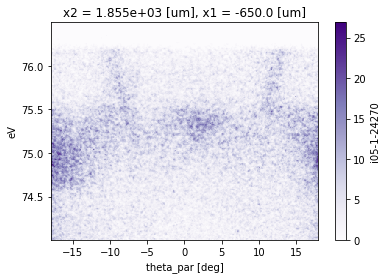

In [63]:
%%time
a.isel(x1=0,x2=0).plot()

But if you need to access the full data set, then it can be slow:

In [62]:
%%time
print(a.sum().compute())

<xarray.DataArray 'i05-1-24270' ()>
array(8.934831e+08, dtype=float32)
CPU times: user 42.8 s, sys: 4.62 s, total: 47.4 s
Wall time: 35.8 s


Alternatively the data can be persisted to memory on load (by default), but then memory should be large enough to handle the dataset...

In [108]:
%%time
a = load_data('example_data/i05-1-24270.nxs',binning=2,eV=slice(74,76.5),theta_par=slice(-18,18))

Persisting data to memory:   0%|          | 0/120 [00:00<?, ?it/s]

CPU times: user 43.8 s, sys: 4.48 s, total: 48.3 s
Wall time: 37.6 s


Now computations are much faster

In [65]:
%%time
a.sum().compute()

CPU times: user 843 ms, sys: 556 ms, total: 1.4 s
Wall time: 258 ms


<xarray.DataArray 'i05-1-24270' ()>
array(8.934831e+08, dtype=float32)

We can integrate over the energy and angle axes to give a total intensity map, using the shortcut `.Tot()` method:

In [5]:
help(Tot)

Help on function Tot in module PyPhoto.display.nanoARPES:

Tot(data, spatial_int=False)
    Quick helper tool for integrating spatial map data over energy and angle (default) or over spatial
    dimensions
    
    Input:
        data - the 4D data from the spatial map (xarray)
        spatial_int (optional, default = False) - flag to indicate integration should be performed over
         the spatial dimensions
    
    Output:
        data_tot - the integrated data (xarray).



CPU times: user 1.4 s, sys: 261 ms, total: 1.66 s
Wall time: 265 ms


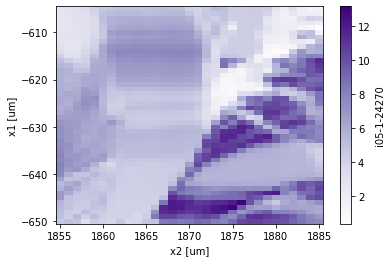

In [66]:
%%time
a.Tot().plot()

We can integrate over the spatial directions to see the average dispersion by additionally passing the flag `spatial_int=True`:

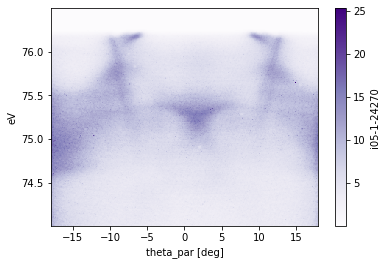

In [67]:
atot = a.Tot(True)
atot.plot(y='eV')

### Facetted plot
We can make a facted plot of the data across the map to give a snapshot overview, by using the in-built 4D plotting capabilities of xarray, while subselecting from the array to ensure a reasoanble number of plots:

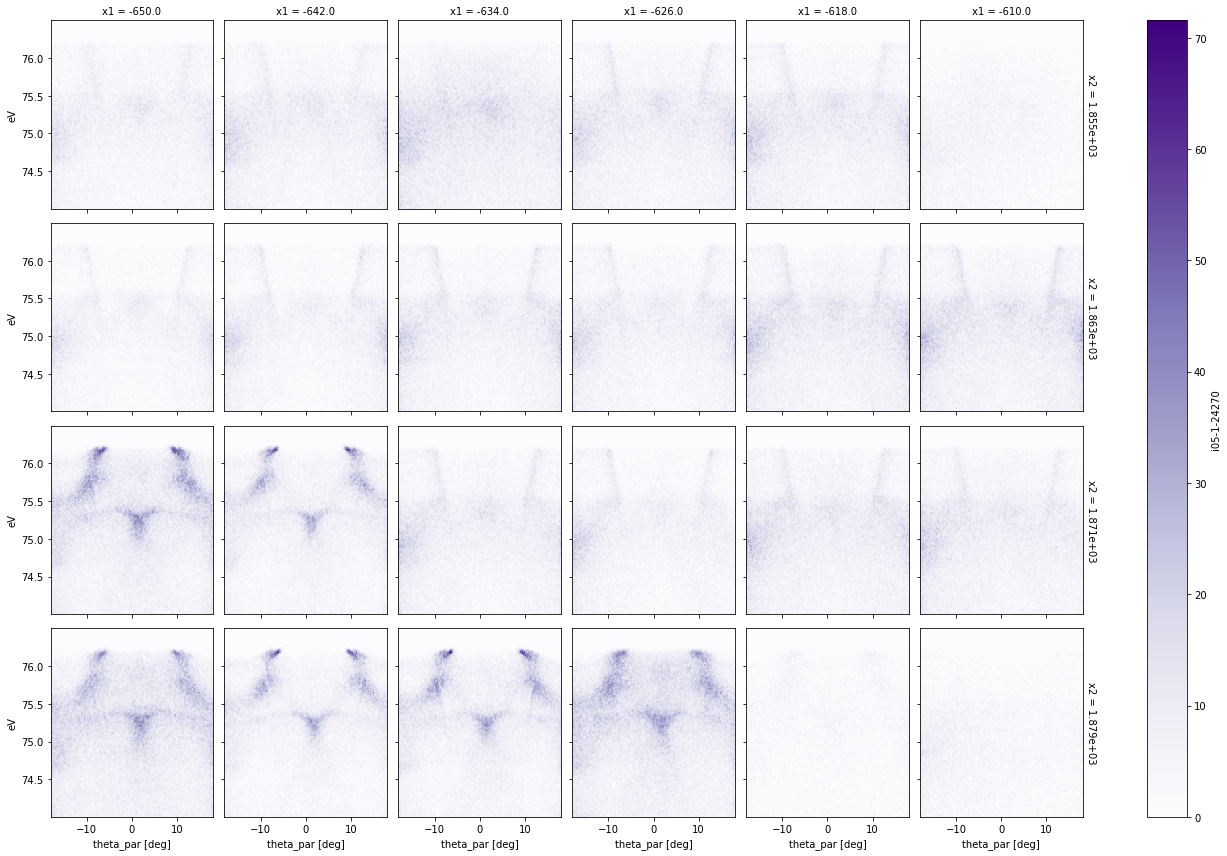

In [68]:
a.isel(x1=slice(0,None,8),x2=slice(0,None,8)).plot(y='eV',col='x1',row='x2')

### Sharpness estimation
We can get a suggestion of the sharpest points to measure using the `.sharpness` tool

In [69]:
help(sharpness)

Help on function sharpness in module peaks.display.nanoARPES:

sharpness(data, smooth_theta_par=0.1, smooth_eV=0.02, **kwargs)
    Sharpness estimation from spatial map data, useful for determining where to measure, in particular from
    noisy map data
    
    Input:
        data - the 4D data from the spatial map (xarray, in theta_par vs eV format)
        smooth_theta_par - FWHM for data smoothing along theta_par axis (default 0.1 deg)
        smooth_eV - FWHM for data smoothing along eV axis (default 0.02 eV)
        **kwargs - additional arguments to pass to the plotting function (standard matplotlib calls),
          all passed to displayed dispersions, if cmap specified, this is also passed to the var map
    
    Returns:
        Plot



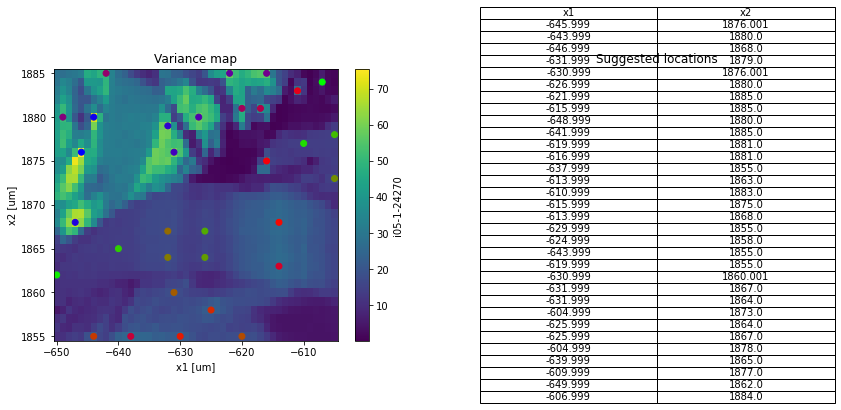

Suggested points:


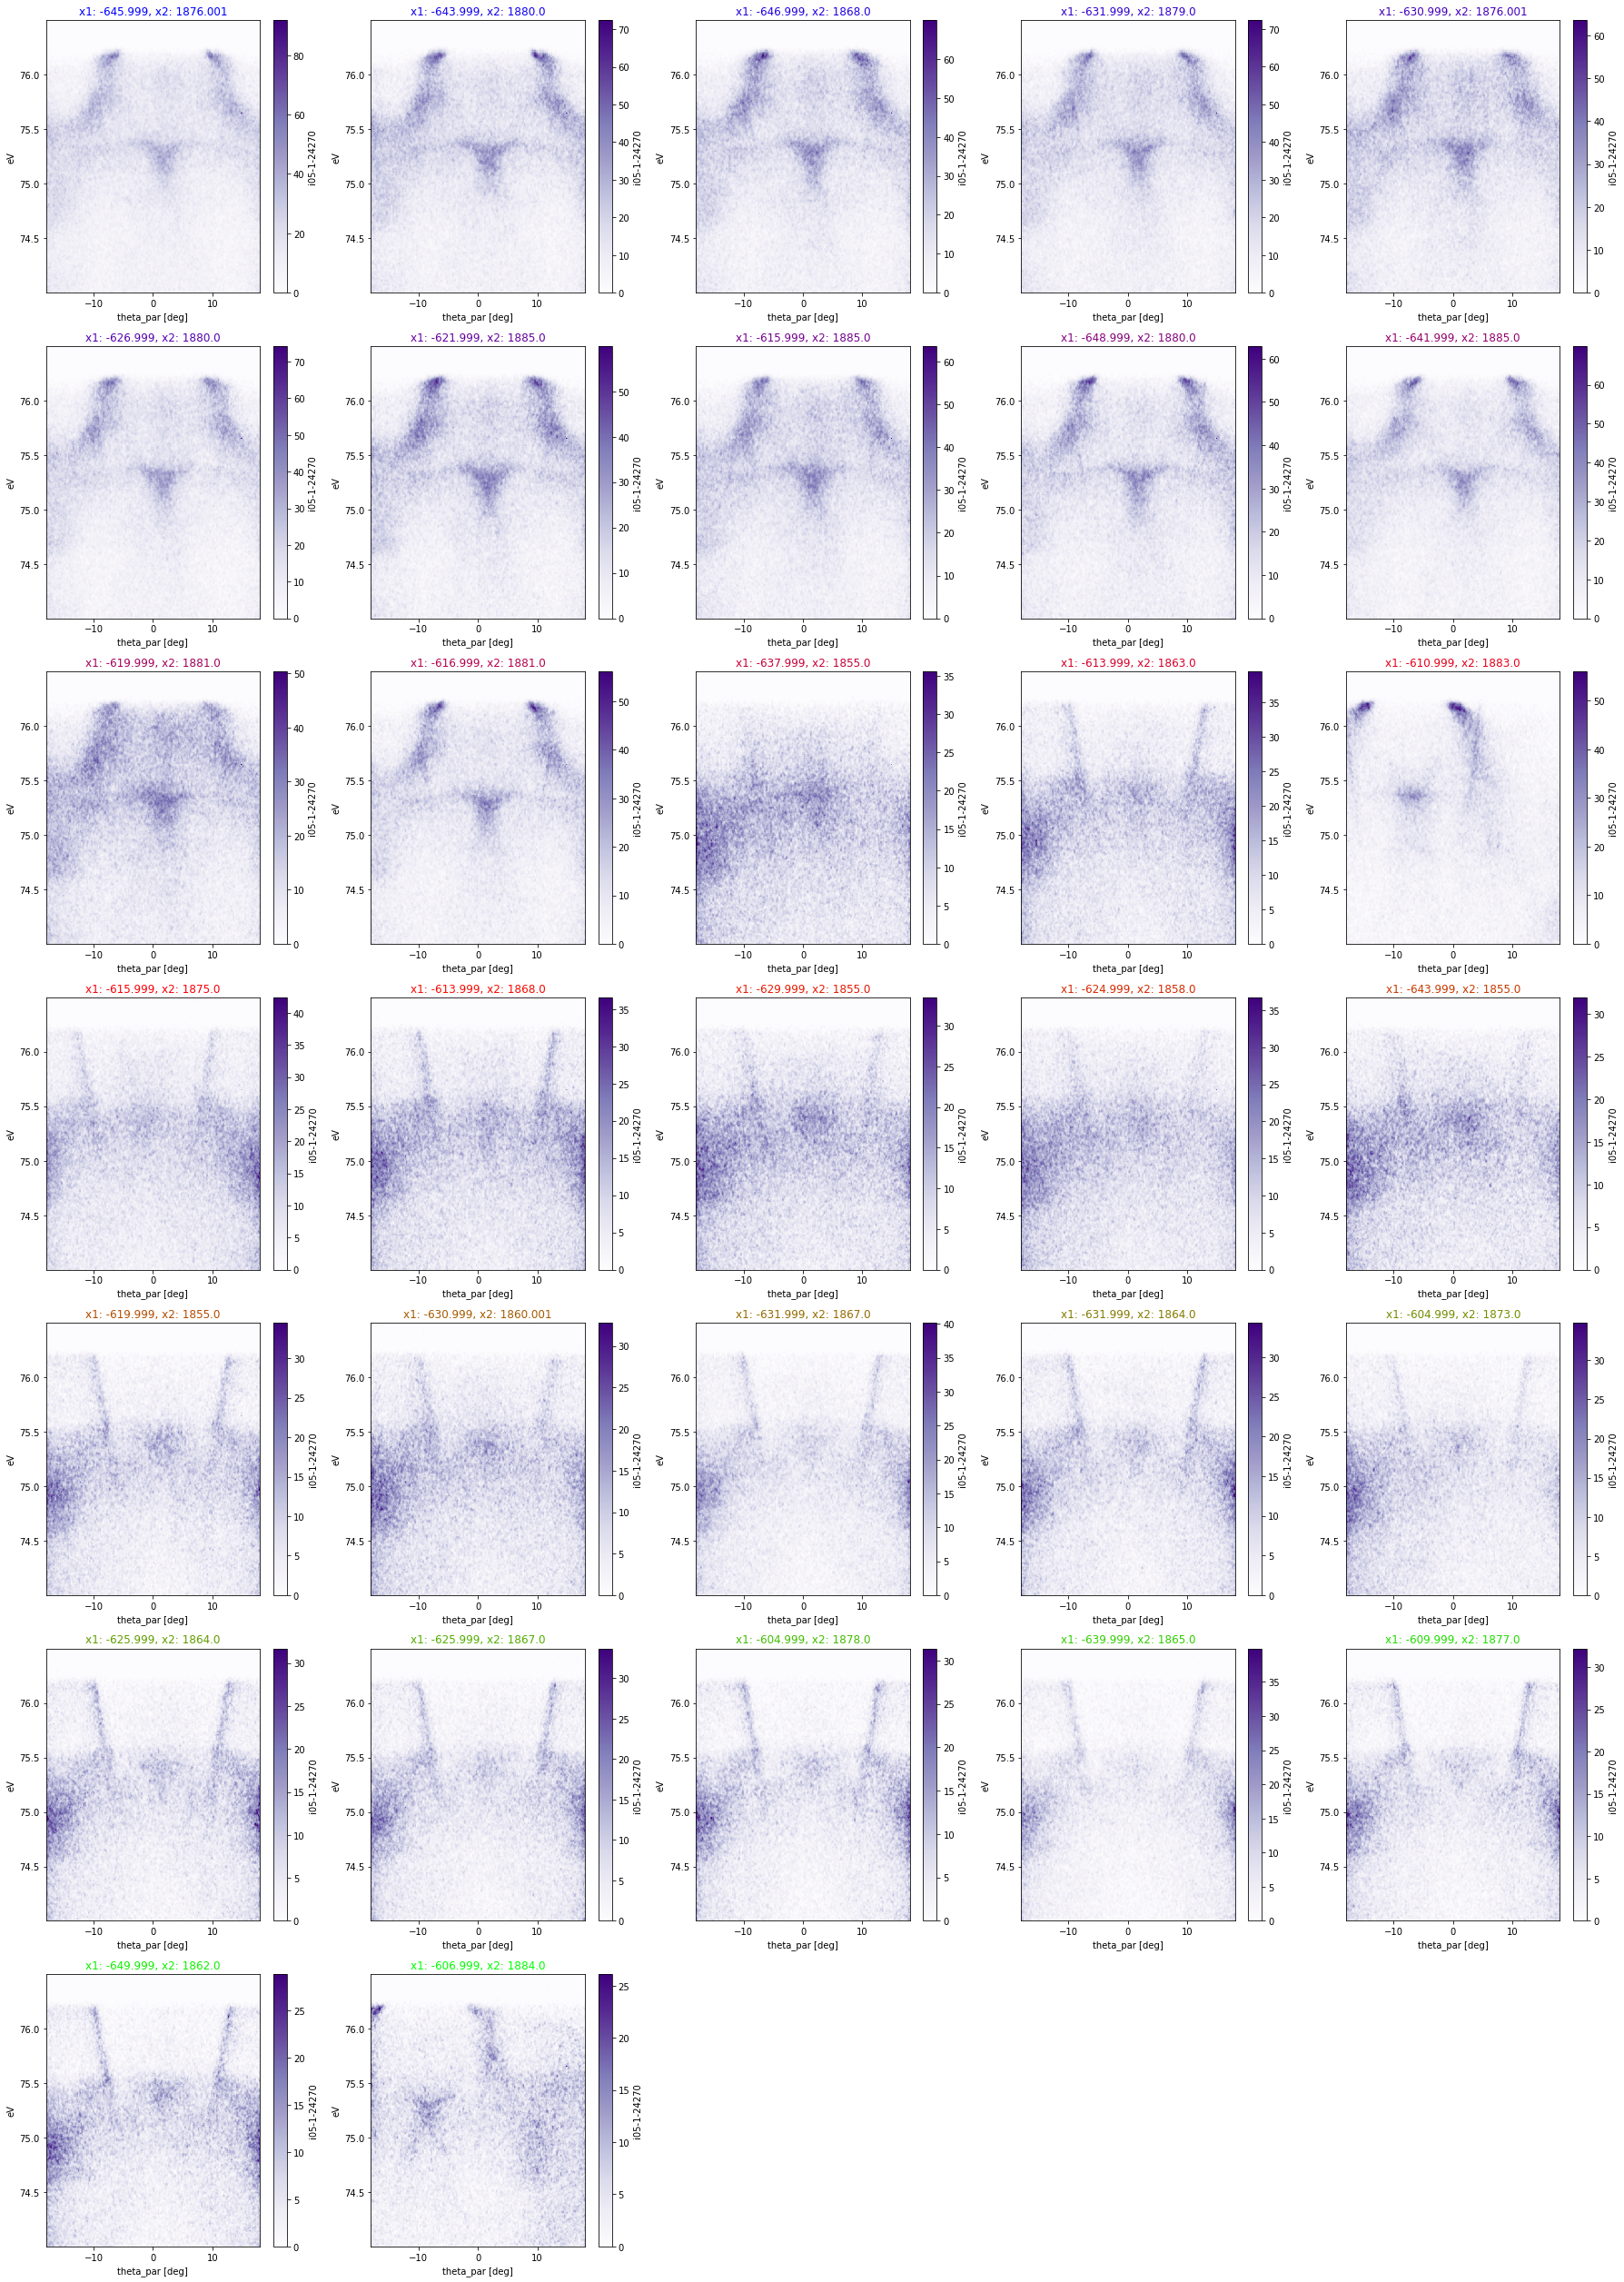

In [112]:
a.sharpness()

It doesn't always work all that well when the map is large like this, but can be a useful guide in some cases...

## Masking

Often in nano-ARPES, we will want to bin over a region of interest in the data, either in E and angle to make a  spatial map based on some feature of interest in the dispersion, or over x1 and x2 in order to generate a dispersion based on the spatial average over a portion of the map.

For simple rectangular binning, this can be performed using the sel functionality of xarray. E.g.:

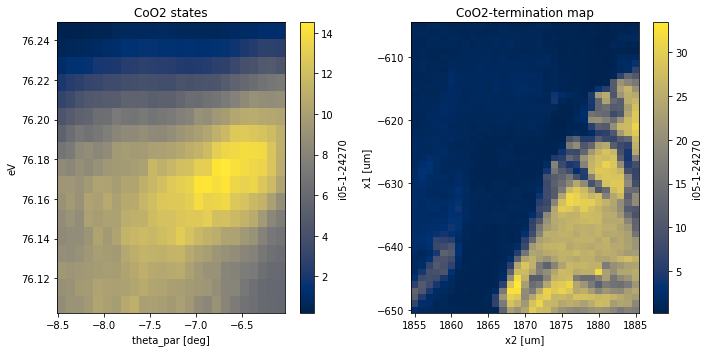

In [72]:
fig, axes = plt.subplots(ncols=2, figsize=(10,5))

#E.g. select a region that covers one of the sets of surface states in the mean dispersion
atot.sel(eV=slice(76.1,76.25),theta_par=slice(-8.5,-6)).plot(y='eV', ax=axes[0], cmap='cividis')
axes[0].set_title('CoO2 states')

#Select and average over this over the map:
a.sel(eV=slice(76.1,76.25),theta_par=slice(-8.5,-6)).mean(['eV','theta_par']).plot(ax=axes[1], cmap='cividis')
axes[1].set_title('CoO2-termination map')
plt.tight_layout()

### ROI_select

In [73]:
help(ROI_select)

Help on function ROI_select in module peaks.display.ROI:

ROI_select(data, ROI_in, return_masked=False)
    This function takes a multi-dimensional data array, takes the mean over 2 of these directions defined by a polygon region of interest. If this is rectangular, it is equivalent to a simple .sel over those dimensions followed by a mean, but an arbitrary polygon can be used to defined the ROI.
    
    Input:
        data - The multi-dimensional data to apply the ROI to (xarray)
        ROI_in - Dictionary of two lists, containing the vertices of the polygon for the ROI definition, in the form {'dim1': [pt1,pt2,pt3,...], 'dim2'=[pt1',pt2',pt3',...]}. As many points can be specified as required, but this should be given with the same number of points for each dimension.
        return_masked (optional, default=False) - call with return_masked=True to return the masked data, rather than taking the mean over the ROI dimensions
    
    Returns:
        masked_data - The original data w

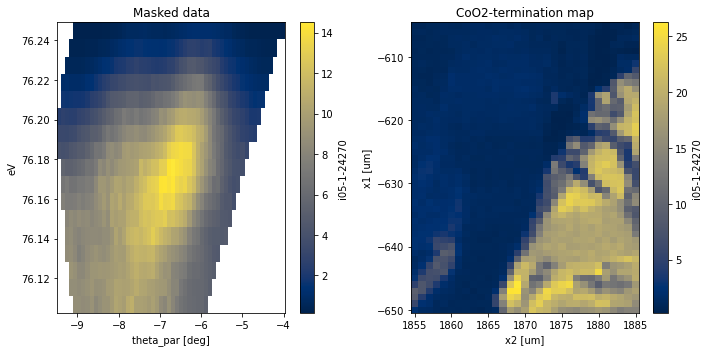

In [74]:
fig, axes = plt.subplots(ncols=2, figsize=(10,5))

#Select a region that covers one of the sets of surface states in the mean dispersion, now with a non-rectangualar mask
#Define an ROI as a dictionary
ROI1 = {'eV': [76.1,76.2,76.25,76.25,76.1], 'theta_par': [-9.1,-9.5,-9,-4,-6]}

#Return with return_masked=True to get the full masked data back
b = a.ROI_select(ROI1,return_masked=True)
b.mean(['x1','x2']).plot(y='eV', ax=axes[0], cmap='cividis')
axes[0].set_title('Masked data')

#Call without return_masked (or return_masked=False) to integrate over this ROI and return the relevant map
b = a.ROI_select(ROI1)
b.plot(ax=axes[1], cmap='cividis')
axes[1].set_title('CoO2-termination map')

plt.tight_layout()

### ROI_plot

In [75]:
help(ROI_plot)

Help on function ROI_plot in module peaks.display.ROI:

ROI_plot(ROI, **kwargs)
    This function plots an ROI.
    
    Input:
        ROI - Dictionary of two lists, containing the vertices of the polygon for the ROI definition, in the form {'dim1': [pt1,pt2,pt3,...], 'dim2'=[pt1',pt2',pt3',...]}. As many points can be specified as required, but this should be given with the same number of points for each dimension.
        **kwargs:
            - y = dim (str) to specify which dimension to plot in the y-direction
            - x = dim (str) to specify which dimension to plot in the y-direction (only one of these needs to be specified, the other is set automatically)
            - label (string), optional argument to pass to a legend to label the ROI
            - loc, standard matplotlib call to specify legend location
            - other standard matplotlib calls to pass to the plot, including ax= for specific axis call
    
    Returns:
        plot - Makes a new plot of the ROI, o

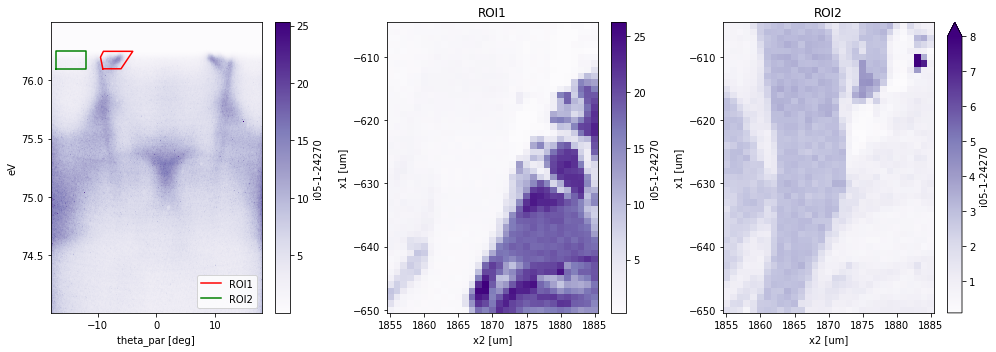

In [76]:
#First, let's define a second ROI
ROI2 = {'eV': [76.1,76.25,76.25,76.1], 'theta_par': [-17,-17,-12,-12]}

fig, axes = plt.subplots(ncols=3, figsize=(14,5))
atot.plot(y='eV', ax=axes[0])
ROI_plot(ROI1, y='eV', color='r', label='ROI1', ax=axes[0])
ROI_plot(ROI2, y='eV', color='g', label='ROI2', ax=axes[0],loc='lower right')

#Plot the corresponding spatial maps
b.plot(ax=axes[1]) #ROI1 region from above
axes[1].set_title('ROI1')

c = a.ROI_select(ROI2)
c.plot(ax=axes[2],vmax=8)
axes[2].set_title('ROI2')

plt.tight_layout()

Look at the difference plot of these two spatial maps to give an idea of the different teminations and features

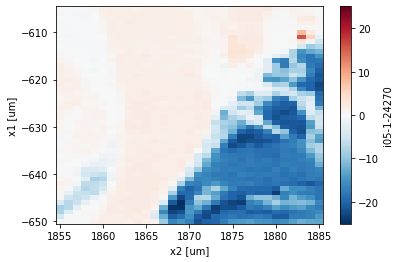

In [77]:
diff = c-b
diff.plot()

We can also call the ROI functions on different axes. E.g. to extract ROI from the spatial dimensions:

In [79]:
#Spatial map
amap = a.Tot()

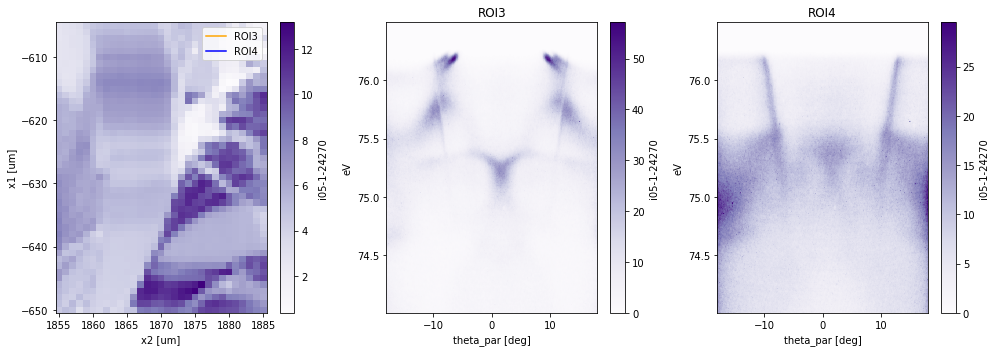

In [80]:
fig, axes = plt.subplots(ncols=3, figsize=(14,5))

amap.plot(ax=axes[0])

#Define and plot the ROIs
ROI3 = {'x1': [-642,-640,-635,-636], 'x2': [1871,1883,1883,1877]}
ROI_plot(ROI3, y='x2', color='orange', label='ROI3', ax=axes[0])
ROI4 = {'x1': [-620,-620,-608,-608], 'x2': [1862,1870,1869,1862]}
ROI_plot(ROI4, y='x2', color='blue', label='ROI4', ax=axes[0])

d = a.ROI_select(ROI3)
d.plot(ax=axes[1],y='eV')
axes[1].set_title('ROI3')
e = a.ROI_select(ROI4)
e.plot(ax=axes[2],y='eV')
axes[2].set_title('ROI4')

plt.tight_layout()

### Interactive spatial map explorer
One of the interactive UIs works on spatial map data. Call with the general `disp` function, and the relevant UI is loaded given the data loaded in. On tab two, you can select ROIs grapically, and save them using the buttons shown. If you click `Save and Exit`, these ROIs are written to the attributes of the wave.

In [81]:
help(disp)

Help on function disp in module peaks.GUI.displayGUI:

disp(data)
    Master load function for GUI data display panels. Currently works with single 2D dataarray,
    a list of 2D dataarrays, and 4D dataarray of spatial mapping data.
    
        Input:
            data - the data to display
    
        Returns:
            null - opens the relevant data display panel



To run this example, open the map using the cell below, and make two ROIs, one covering the flat states at the Fermi level on the left, one covering the bright hole bands at EF, then click `Save and Exit`

In [82]:
a.disp()

qt.pointer.dispatch: delivering touch release to same window QWindow(0x0) not QWidgetWindow(0x7f9bd35206f0, name="disp4d_panelWindow")
qt.pointer.dispatch: skipping QEventPoint(id=1 ts=0 pos=0,0 scn=1221.64,728.937 gbl=1221.64,728.937 Released ellipse=(1x1 ∡ 0) vel=0,0 press=-1221.64,-728.937 last=-1221.64,-728.937 Δ 1221.64,728.937) : no target window
/Users/pdk6/Dropbox/Work/Lab/Software/PyPhoto/PyPhoto_Master/venv_office/lib/python3.8/site-packages/torch/distributed/distributed_c10d.py:181: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


The cell below will be generated when you click `Save and Exit` with your own ROI information

In [88]:
a.attrs['ROI']={'ROI_1': {'eV': [76.24368329417611, 76.05788186140603, 76.07404553541822, 76.25984696818828], 'theta_par': [8.32100034029851, 7.783468018573799, 11.108105428441128, 11.780020830597017]}, 'ROI_2': {'eV': [76.23560145717, 76.07404553541822, 76.07404553541822, 76.21943778315782], 'theta_par': [-17.346168022056382, -17.211784941625204, -11.065102842703148, -11.602635164427856]}}

You can then use these with the functions above for static analysis.

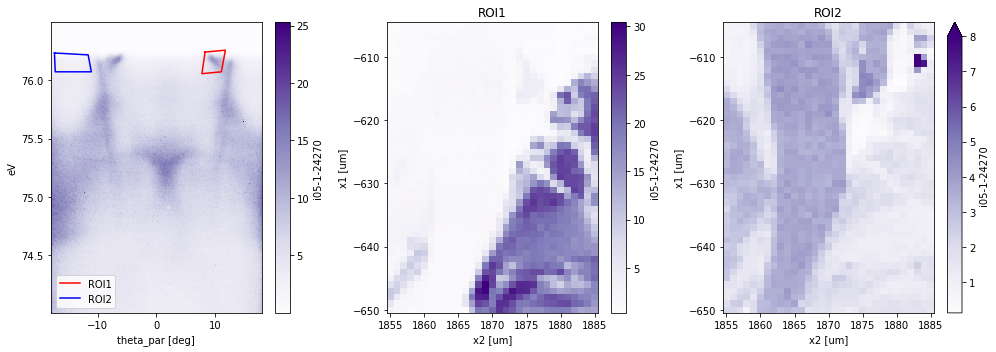

In [89]:
fig, axes = plt.subplots(ncols=3, figsize=(14,5))
atot = a.mean(['x1','x2'], keep_attrs=True)
atot.plot(y='eV', ax=axes[0])
ROI_plot(a.ROI['ROI_1'], y='eV', color='r', label='ROI1', ax=axes[0])
ROI_plot(a.ROI['ROI_2'], y='eV', color='b', label='ROI2', ax=axes[0])

#Plot the corresponding spatial maps
b = a.ROI_select(a.ROI['ROI_1'])
b.plot(ax=axes[1]) #ROI1 region from above
axes[1].set_title('ROI1')

c = a.ROI_select(a.ROI['ROI_2'])
c.plot(ax=axes[2],vmax=8)
axes[2].set_title('ROI2')

plt.tight_layout()

If there is an ROI set already loaded in the attributes, then this will be loaded in to the display panel when loading, allowing the ROIs to be added to (or deleted) via the panel

In [90]:
a.disp()

## Slant correction

At I05-nano, at least during the beamtimes in 2021 and 2022, the Scienta DA30 has a weird slant on the detector. This can be removed using `.slant_correct` (can also be applied to dispersions and higher-D data)

In [96]:
a = load_data('example_data/i05-1-31473.nxs')

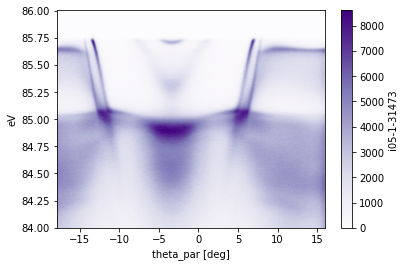

In [97]:
a.plot()

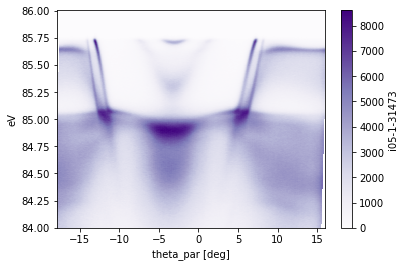

In [98]:
b = a.slant_correct()
b.plot()